In [1]:
from qiskit import QuantumCircuit
from qiskit.compiler import transpile
from qiskit_aer import AerSimulator
from qiskit.converters import circuit_to_dag, dag_to_circuit
from qiskit_aer.noise import depolarizing_error, NoiseModel
from qiskit.quantum_info import SparsePauliOp

from qiskit.primitives import BackendEstimator

from zne import zne, ZNEStrategy
from zne.noise_amplification import *
from zne.extrapolation import *

import numpy as np
import matplotlib.pyplot as plt

import json, os, pickle, random
import numpy as np
from tqdm.notebook import tqdm
import pandas as pd

import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn as nn

import qiskit
from qiskit import QuantumCircuit, execute
from qiskit.compiler import transpile
from qiskit_aer import AerSimulator, QasmSimulator
from qiskit.converters import circuit_to_dag, dag_to_circuit
from qiskit.quantum_info import SparsePauliOp, Operator
from qiskit.circuit.library import CXGate, RXGate, IGate, ZGate
from qiskit.providers.fake_provider import FakeMontreal, FakeLima

from blackwater.data.utils import (
    generate_random_pauli_sum_op,
    create_estimator_meas_data,
    circuit_to_graph_data_json,
    get_backend_properties_v1,
    encode_pauli_sum_op,
    create_meas_data_from_estimators
)

from mlp import MLP1, MLP2, MLP3, encode_data

from mbd_utils import cal_z_exp, generate_disorder, construct_mbl_circuit, calc_imbalance, modify_and_add_noise_to_model

import matplotlib.pyplot as plt
import seaborn as sns
from noise_utils import AddNoise

In [2]:
backend = FakeLima()
properties = get_backend_properties_v1(backend)

## Local
backend_ideal = QasmSimulator() # Noiseless
backend_noisy = AerSimulator.from_backend(FakeLima()) # Noisy

run_config_ideal = {'shots': 10000, 'backend': backend_ideal, 'name': 'ideal'}
run_config_noisy = {'shots': 10000, 'backend': backend_noisy, 'name': 'noisy'}

In [3]:
def fix_random_seed(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    print(f'random seed fixed to {seed}')

In [4]:
with open('./zne_mitigated/ising_init_from_qasm_extra_degree2.pk', 'rb') as infile:
    zne_mitigated = pickle.load(infile)

In [5]:
import re
def load_circuits(data_dir, f_ext='.json'):
    circuits = []
    ideal_exp_vals = []
    noisy_exp_vals = []
    data_files = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith(f_ext)]
    steps = []
    for data_file in tqdm(data_files, leave=True):
        if f_ext == '.json':
            for entry in json.load(open(data_file, 'r')):
                circuits.append(QuantumCircuit.from_qasm_str(entry['circuit']))
                ideal_exp_vals.append(entry['ideal_exp_value'])
                noisy_exp_vals.append(entry['noisy_exp_values'])
        elif f_ext == '.pk':
            step = int(re.search(r'\d+', data_file.split('/')[-1]).group())
            for entry in pickle.load(open(data_file, 'rb')):
                steps.append(step)
                circuits.append(entry['circuit'])
                ideal_exp_vals.append(entry['ideal_exp_value'])
                noisy_exp_vals.append(entry['noisy_exp_values'])
    return circuits, ideal_exp_vals, noisy_exp_vals, steps

circuits, ideal_exp_vals, noisy_exp_vals, steps = load_circuits('./data/ising_init_from_qasm/val_extra/', '.pk')
print(len(circuits))

noisy_exp_vals = [x[0] for x in noisy_exp_vals]

  0%|          | 0/30 [00:00<?, ?it/s]

9000


In [6]:
df = []
for circ, ideal, zne, noisy, step  in zip(circuits, ideal_exp_vals, zne_mitigated, noisy_exp_vals, steps):
    df.append([circ, ideal, zne, noisy, step])
df = pd.DataFrame(df)
df = df.rename(columns={0: 'circuits', 1:'ideal_exp_vals', 2: 'zne_mitigated', 3: 'noisy_exp_vals', 4: 'steps'})
df

,circuits,ideal_exp_vals,zne_mitigated,noisy_exp_vals,steps
0,"((Instruction(name='rz', num_qubits=1, num_clb...","[0.071, 0.1072, -0.1968, -0.051]","[0.018362418084157953, -0.01898522157541496, -...","[-0.002, 0.0048, -0.0514, -0.0602]",19
1,"((Instruction(name='rz', num_qubits=1, num_clb...","[0.0678, -0.116, -0.0138, 0.1622]","[0.007899238027450432, -0.05481477108939975, -...","[0.0078, -0.0242, -0.0242, -0.0416]",19
2,"((Instruction(name='rz', num_qubits=1, num_clb...","[-0.4098, 0.1788, -0.8624, -0.2374]","[-0.3100039510100011, 0.08443378978914502, -0....","[-0.2226, 0.0342, -0.2332, -0.1506]",19
3,"((Instruction(name='rz', num_qubits=1, num_clb...","[-0.062, 0.0372, 0.0698, 0.003]","[-0.059017439542192164, -0.020342518492002318,...","[-0.0346, -0.008, -0.0388, -0.066]",19
4,"((Instruction(name='rz', num_qubits=1, num_clb...","[-0.6332, -0.2154, 0.1742, -0.0236]","[-0.29411231985781416, -0.07723876352570024, -...","[-0.2022, -0.0628, -0.0294, -0.0464]",19
...,...,...,...,...,...
8995,"((Instruction(name='rz', num_qubits=1, num_clb...","[-0.1132, -0.0928, 0.196, 0.0616]","[-0.11991445762840146, -0.05067705218358321, 0...","[-0.0786, -0.0308, 0.0018, -0.0104]",9
8996,"((Instruction(name='rz', num_qubits=1, num_clb...","[0.435, 0.3058, -0.5422, -0.0294]","[0.4124723900630041, 0.17850227566551813, -0.3...","[0.3408, 0.0986, -0.241, -0.1136]",9
8997,"((Instruction(name='rz', num_qubits=1, num_clb...","[-0.0606, 0.0154, 0.0626, -0.0618]","[-0.08927788824029376, 0.01743249281585344, -0...","[-0.0674, -0.007, -0.017, -0.103]",9
8998,"((Instruction(name='rz', num_qubits=1, num_clb...","[-0.0348, -0.1158, 0.197, 0.0966]","[-0.043079484642396595, -0.055749583889638875,...","[-0.0478, -0.046, 0.0058, -0.0018]",9


/var/folders/kj/mfqyg_tj77nf4gt67lvscdkw0000gn/T/ipykernel_30515/2320248887.py:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_mean = df.groupby('steps').agg('mean')
/var/folders/kj/mfqyg_tj77nf4gt67lvscdkw0000gn/T/ipykernel_30515/2320248887.py:10: FutureWarning: The default value of numeric_only in DataFrameGroupBy.std is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_ste = df.groupby('steps').agg('std') / np.sqrt(len(df[df['steps']==0]))


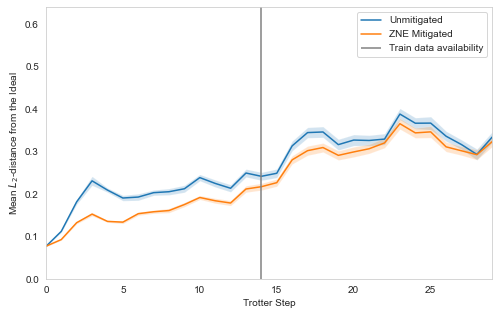

In [7]:
######################### Sanity check #########################
def l2_dist(list1, list2):
    return np.sqrt(np.sum([(a - b)**2 for a, b in zip(list1, list2)]))

for col in df.columns:
    if col not in ['steps', 'ideal_exp_vals', 'circuits']:
        df[f'L2_{col}'] = df.apply(lambda row: l2_dist(row['ideal_exp_vals'], row[col]), axis=1)

df_mean = df.groupby('steps').agg('mean')
df_ste = df.groupby('steps').agg('std') / np.sqrt(len(df[df['steps']==0]))

plt.style.use({'figure.facecolor':'white'})
plt.figure(figsize=(8, 5))
steps = sorted(set(df.steps))
legend_labels = ['Unmitigated', 'ZNE Mitigated']
for i, col in enumerate(['L2_noisy_exp_vals', 'L2_zne_mitigated']):
    plt.plot(steps, df_mean[col], label=legend_labels[i])
    plt.fill_between(x=steps, y1=df_mean[col]-df_ste[col], y2=df_mean[col]+df_ste[col], alpha=0.2)
plt.xlabel('Trotter Step')
plt.ylabel(r'Mean $L_2$-distance from the Ideal')
plt.ylim([0, 0.64])
plt.xlim([0, 29])
plt.vlines(x=14, ymin=0, ymax=1, color='gray', label='Train data availability')
plt.legend()
plt.grid(None)
plt.show()

In [7]:
train_circuits = []
test_circuits = []
train_zne_mitigated = []
test_zne_mitigated = []
train_noisy = []
test_noisy = []
train_step = []
test_step = []
test_ideal = []
sep = 150
for s in set(steps):
    df_step = df[df['steps'] == s]
    train_circuits += list(df_step['circuits'][:sep])
    test_circuits += list(df_step['circuits'][sep:])
    train_zne_mitigated += list(df_step['zne_mitigated'][:sep])
    test_zne_mitigated += list(df_step['zne_mitigated'][sep:])
    train_noisy += list(df_step['noisy_exp_vals'][:sep])
    test_noisy += list(df_step['noisy_exp_vals'][sep:])
    train_step += [s] * sep
    test_step += [s] * (300-sep)
    test_ideal += list(df_step['ideal_exp_vals'][sep:])

In [8]:
X_train, y_train = encode_data(train_circuits, properties, train_zne_mitigated, train_noisy, num_qubits=4)
X_test, y_test = encode_data(test_circuits, properties, test_zne_mitigated, test_noisy, num_qubits=4)

/Users/haoranliao/GitHub/blackwater/docs/tutorials/mlp.py:201: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1670525699189/work/torch/csrc/utils/tensor_new.cpp:233.)
  y = torch.tensor(ideal_exp_vals, dtype=torch.float32)


In [9]:
BATCH_SIZE = 32
fix_random_seed(0)
train_dataset = TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train))
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataset = TensorDataset(torch.Tensor(X_test), torch.Tensor(y_test))
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE*1000, shuffle=False)

random seed fixed to 0


In [10]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
rfr_tree_list = []
for q in range(4):
    rfr = RandomForestRegressor(n_estimators=300)
    rfr.fit(X_train, y_train[:, q])
    rfr_tree_list.append(rfr)

In [11]:
tree_pred = []
for x in tqdm(X_test):
    pred = []
    for q, model in enumerate(rfr_tree_list):
        pred.append(model.predict(x.reshape(1, -1)))
    pred = np.array(pred).transpose()
    tree_pred.append(pred)

  0%|          | 0/4500 [00:00<?, ?it/s]

In [19]:
df_pred = []

for i, (circ, ideal_exp_val, noisy_exp_val, zne_mitigated, pred_exp_val, step) in tqdm(enumerate(zip(test_circuits, test_ideal, test_noisy, test_zne_mitigated, tree_pred, test_step)), total=len(test_circuits)):
    row = dict()
    row['ideal'] = ideal_exp_val
    row['zne_mitigated'] = zne_mitigated
    row['noisy'] = noisy_exp_val
    row['tree_pred'] = pred_exp_val[0]
    row['steps'] = step
    df_pred.append(row)

df_pred = pd.DataFrame(df_pred)

  0%|          | 0/4500 [00:00<?, ?it/s]

/var/folders/kj/mfqyg_tj77nf4gt67lvscdkw0000gn/T/ipykernel_97567/375005127.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_pred_mean = df_pred.groupby('steps').agg('mean')
/var/folders/kj/mfqyg_tj77nf4gt67lvscdkw0000gn/T/ipykernel_97567/375005127.py:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.std is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_pred_ste = df_pred.groupby('steps').agg('std') / np.sqrt(len(df_pred[df_pred['steps']==0]))


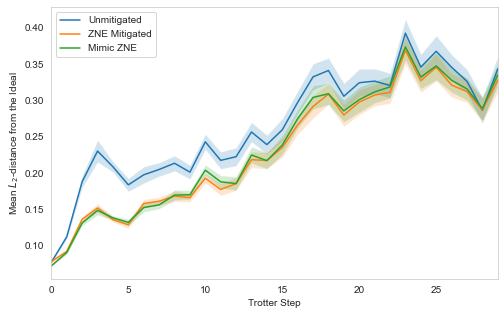

In [20]:
def l2_dist(list1, list2):
    return np.sqrt(np.sum([(a - b)**2 for a, b in zip(list1, list2)]))

for col in df_pred.columns:
    if col not in ['ideal', 'steps']:
        df_pred[f'L2_{col}'] = df_pred.apply(lambda row: l2_dist(row['ideal'], row[col]), axis=1)

df_pred_mean = df_pred.groupby('steps').agg('mean')
df_pred_ste = df_pred.groupby('steps').agg('std') / np.sqrt(len(df_pred[df_pred['steps']==0]))

plt.style.use({'figure.facecolor':'white'})
plt.figure(figsize=(8, 5))
steps = sorted(set(df_pred.steps))
legend_labels = ['Unmitigated', 'ZNE Mitigated', 'Mimic ZNE']
for i, col in enumerate(['L2_noisy', 'L2_zne_mitigated', 'L2_tree_pred']):
    plt.plot(steps, df_pred_mean[col], label=legend_labels[i])
    plt.fill_between(x=steps, y1=df_pred_mean[col]-df_pred_ste[col], y2=df_pred_mean[col]+df_pred_ste[col], alpha=0.2)
plt.xlabel('Trotter Step')
plt.ylabel(r'Mean $L_2$-distance from the Ideal')
# plt.ylim([0, 0.64])
plt.xlim([0, 29])
plt.legend()
plt.grid(None)
plt.show()

In [18]:
# to_dump = {
#     'df_pred': df_pred,
# }
# with open('/Users/haoranliao/GitHub/blackwater/docs/paper_figures/mimic_zne.pk', 'wb') as file:
#     pickle.dump(to_dump, file)

random seed fixed to 0
RMSE_noisy_0: 0.03937381155162309
RMSE_mitigated_0: 0.02305869095977981
RMSE_noisy_1: 0.029509902593597793
RMSE_mitigated_1: 0.02089014026170997
RMSE_noisy_2: 0.05621530586449455
RMSE_mitigated_2: 0.023838483487746528
RMSE_noisy_3: 0.04218553392709474
RMSE_mitigated_3: 0.021323284015479047
RMSE_noisy: 0.04289787661801891
RMSE_mitigated: 0.02231063045463359


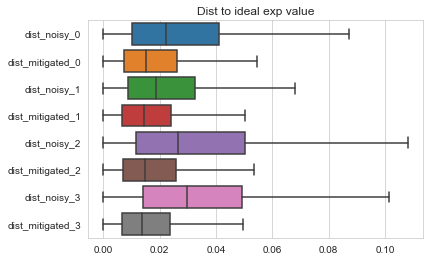

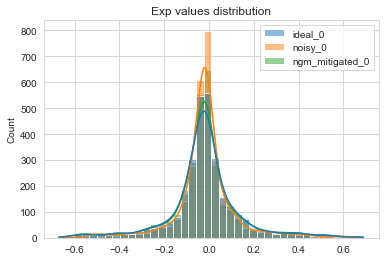

In [93]:
fix_random_seed(0)

distances = []

num_spins = 4
even_qubits = np.linspace(0, num_spins, int(num_spins/2), endpoint=False)
odd_qubits = np.linspace(1, num_spins+1, int(num_spins/2), endpoint=False)

for batch_X, batch_y in test_loader:
    out = []
    for q, model in enumerate(rfr_tree_list):
        out.append(model.predict(batch_X[:, :]))
    out = np.array(out).transpose()
    # out = rfr.predict(batch_X[:, -4:])

    for ideal, noisy, ngm_mitigated in zip(
        batch_y.tolist(),
        batch_X[:, -4:].tolist(),
        out.tolist()
    ):
        imbalance_ideal = calc_imbalance([ideal], even_qubits, odd_qubits)[0]
        imbalance_noisy = calc_imbalance([noisy], even_qubits, odd_qubits)[0]
        imbalance_mitigated = calc_imbalance([ngm_mitigated], even_qubits, odd_qubits)[0]
        for q in range(4):
            ideal_q = ideal[q]
            noisy_q = noisy[q]
            ngm_mitigated_q = ngm_mitigated[q]
            distances.append({
                f"ideal_{q}": ideal_q,
                f"noisy_{q}": noisy_q,
                f"ngm_mitigated_{q}": ngm_mitigated_q,
                f"dist_noisy_{q}": np.abs(ideal_q - noisy_q),
                f"dist_mitigated_{q}": np.abs(ideal_q - ngm_mitigated_q),
                f"dist_sq_noisy_{q}": np.square(ideal_q - noisy_q),
                f"dist_sq_mitigated_{q}": np.square(ideal_q - ngm_mitigated_q),
                "imb_ideal": imbalance_ideal,
                "imb_noisy": imbalance_noisy,
                "imb_ngm": imbalance_mitigated,
                "imb_diff": imbalance_ideal - imbalance_mitigated
            })

plt.style.use({'figure.facecolor':'white'})

df = pd.DataFrame(distances)

for q in range(4):
    print(f'RMSE_noisy_{q}:', np.sqrt(df[f"dist_sq_noisy_{q}"].mean()))
    print(f'RMSE_mitigated_{q}:', np.sqrt(df[f"dist_sq_mitigated_{q}"].mean()))

print(f'RMSE_noisy:', np.sqrt(np.mean([df[f"dist_sq_noisy_{q}"].mean() for q in range(4)])))
print(f'RMSE_mitigated:', np.sqrt(np.mean([df[f"dist_sq_mitigated_{q}"].mean() for q in range(4)])))

sns.boxplot(data=df[["dist_noisy_0", "dist_mitigated_0", "dist_noisy_1", "dist_mitigated_1", "dist_noisy_2", "dist_mitigated_2", "dist_noisy_3", "dist_mitigated_3"]], orient="h", showfliers = False)
plt.title("Dist to ideal exp value")
plt.show()

sns.histplot([df['ideal_0'], df['noisy_0'], df["ngm_mitigated_0"]], kde=True, bins=40)
plt.title("Exp values distribution")
plt.show()